In [1]:
import sys
sys.path.append('..')
from od import anchor
import random
from matplotlib import pyplot as plt
from model import pe
import torch
from common.config import grid_size_x, grid_size_y, num_grid

In [2]:
anchors = anchor.generate_anchors()
random.shuffle(anchors)
centers = [[a[0] * .5 + a[2] * .5,  a[1] * .5 + a[3] * .5] for a in anchors]
center = centers[0]

/var/folders/6g/83bk7w6d5nlbhh_5lzmncb0m0000gn/T/ipykernel_76061/3899068330.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  center = torch.tensor(center).view(1, 1, 2)


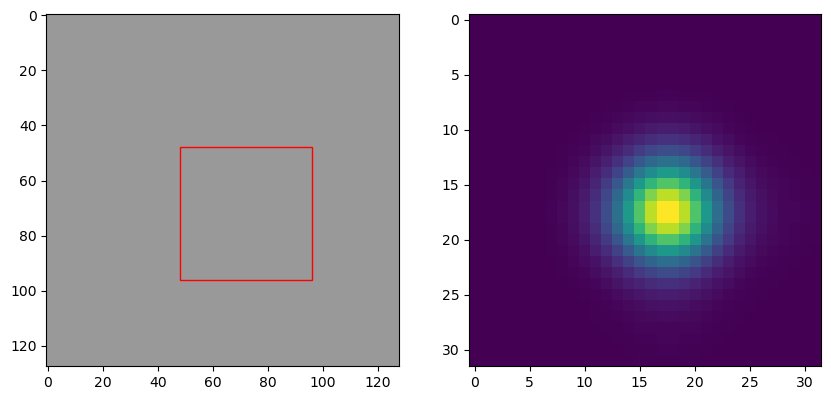

In [47]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
img = torch.ones([128, 128, 3]) * 0.6
axes[0].imshow(img)
x1, y1, x2, y2 = anchors[0]
x1 = x1 * 128
y1 = y1 * 128
x2 = x2 * 128
y2 = y2 * 128
axes[0].add_patch(
    plt.Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, edgecolor='red', lw=1))

pos_emb = pe.Sinusoidal(64)
x = torch.rand([1, grid_size_y, grid_size_x, 2])
coord = pe.gen_pos_2d(x).view(1, num_grid, 2)
pos_emb_ = pos_emb(coord).view(num_grid, 128)

center = torch.tensor(center).view(1, 1, 2)
center_emb = pos_emb(center).view(1, 128)

rsz1 = torch.ones(64) * 12
rsz2 = torch.ones(64) * 12
rsz = torch.concat([rsz1, rsz2], dim=-1).view(1, 128)

attn = (center_emb / rsz  @ pos_emb_.transpose(0, 1)).softmax(dim=-1).view(grid_size_y, grid_size_x)
axes[1].imshow(attn.detach().numpy())


In [3]:
import os
import sys
from matplotlib import pyplot as plt
sys.path.append('..')
import torch
from torch import optim
from od import anno, detr_dataset, detr_model, match, eval, anchor
from common.config import train_annotation_file, train_img_od_dict_file, img_size, \
    train_anchor_batch_size, model_save_dir, device_type, model_save_stride
from od.config import loss_weights
import focalloss
import time
import random
import numpy as np
from torchvision.ops import distance_box_iou_loss
from torch.utils.data import DataLoader
from torchvision import transforms

device = torch.device('cpu')
anchors = torch.tensor(anchor.generate_anchors(variable_stride=True), device=device)
model = detr_model.DETR(d_enc=256, d_head=64, d_enc_coord_emb=32, d_dec_coord_emb=32,
                        n_enc_layer=16, n_dec_layer=6, anchors=anchors, exam_diff=True)
model.to(device)
n_query = len(anchors)

dicts = anno.build_img_dict(train_annotation_file, train_img_od_dict_file, task='od')


In [4]:
ds = detr_dataset.OdDataset(dicts, n_query, train=True, sample_num=4, random_shift=False)
dl = DataLoader(ds, batch_size=2, shuffle=False)
for j, (img, boxes_gt_xyxy, cids_gt, _, img_id) in enumerate(dl):
    img = img.to(device)
    cids_gt = cids_gt.to(torch.long)
    cids_gt = cids_gt.to(device)
    boxes_gt_xyxy = boxes_gt_xyxy.to(device) / max(img_size)
    img = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])(img)

    B = img.shape[0]

    boxes_pred_xyxy, cls_logits_pred, enc_diff, logits_diff, pos_attn = model(img)


/Users/zx/miniforge3/envs/pytorch/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/Users/zx/Documents/ml/restart/notebook/../od/box.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  bboxes_pa

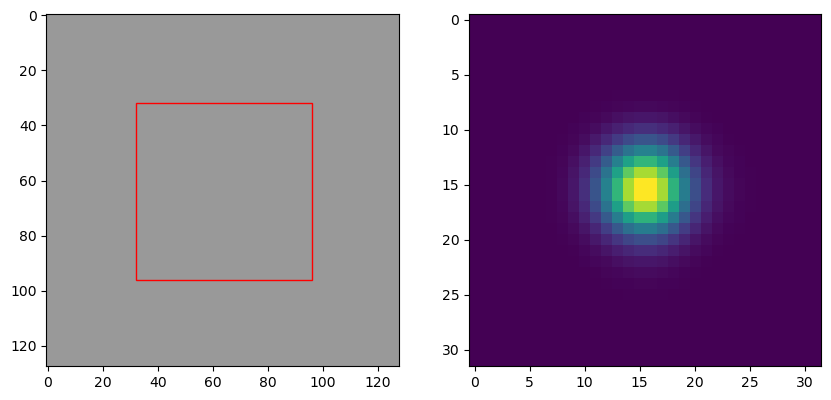

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
img = torch.ones([128, 128, 3]) * 0.6
axes[0].imshow(img)
idx = random.choice(list(range(len(anchors))))
anchors_ = anchors.detach()
x1, y1, x2, y2 = anchors_[idx]
x1 = x1 * 128
y1 = y1 * 128
x2 = x2 * 128
y2 = y2 * 128
axes[0].add_patch(
    plt.Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, edgecolor='red',[]. lw=1))

axes[1].imshow(pos_attn.detach()[0, idx].view(32, 32))

In [9]:
pos_attn.shape

torch.Size([2, 548, 1024])

In [9]:
model.decoder.anchors.shape

torch.Size([548, 4])

In [61]:
a.pop()

6

In [62]:
a

[4, 5]

In [64]:
list(reversed(a))

[5, 4]

In [66]:
a.reverse()

In [67]:
a

[5, 4]

In [68]:
a.pop(0)

5

In [69]:
a

[4]

In [70]:
import numpy as np

In [71]:
a = np.array([3,4,5])

In [72]:
a.tolist()

[3, 4, 5]